In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
from bagsolver.bag import Bag
from bagsolver.utils import load_bag_data, parse_solution
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed

from experiment2 import run

- Experiment má odpovědět na tyto otázky:
- Odpovídají obě závislosti (kvality a času) předpokladům?
- Je některá heuristická metoda systematicky lepší (tzv. dominance) v některém kritériu?
- Jak se liší obtížnost jednotlivých sad z hlediska jednotlivých metod?
- Jaká je závislost maximální chyby (ε) a času FPTAS algoritmu na zvolené přesnosti? Odpovídá předpokladům?

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv("full-to-27-fix3.csv")

In [43]:
df = df.rename(columns={"key": "method"})

In [46]:
import numpy as np

df["abs"] = (df.result - df.target).abs()

In [48]:
df["error"] = df["abs"] / df.target

In [50]:
agg = df[(df.dataset=="NK")].groupby(by=["method", "dataset"])[["elapsed", "error"]].agg(["min", "mean", "max"])

In [55]:
df[(df.method == "dynamic_weight") & (df["abs"] > 0)]

,iid,dataset,size,method,elapsed,result,target,abs,error
67659,43,NK,25,dynamic_weight,1.812678,32651.0,32675,24.0,0.000735


In [51]:
agg

elapsed                      error                \
                              min      mean        max   min          mean   
method          dataset                                                      
branch_bound    NK       0.000048  0.462842  33.754436   0.0  0.000000e+00   
dynamic_cost    NK       0.000014  0.041092   1.255191   0.0  0.000000e+00   
dynamic_weight  NK       0.007218  0.942391   2.755477   0.0  2.130239e-07   
greedy_redux    NK       0.000013  0.000072   0.014111   0.0  8.716242e-03   
greedy_simple   NK       0.000011  0.000054   0.003782   0.0  9.833431e-03   
solve_ftapas_15 NK       0.000213  0.067303   0.312975   0.0  1.023110e-03   
solve_ftapas_30 NK       0.000192  0.034765   0.234962   0.0  3.136849e-03   
solve_ftapas_50 NK       0.000155  0.021032   0.122146   0.0  6.979394e-03   
solve_ftapas_70 NK       0.000134  0.015209   0.106046   0.0  1.037642e-02   

                                   
                              max  
method          dataset            
branch_bound    NK       0.000000  
dynamic_cost    NK       0.000000  
dynamic_weight  NK       0.000735  
greedy_redux    NK       0.359189  
greedy_simple   NK       0.531453  
solve_ftapas_15 NK       1.000000  
solve_ftapas_30 NK       1.000000  
solve_ftapas_50 NK       1.000000  
solve_ftapas_70 NK       1.000000

In [23]:
print(agg.to_latex())

\begin{tabular}{llrrrrrr}
\toprule
                &    & \multicolumn{3}{l}{elapsed} & \multicolumn{3}{l}{delta} \\
                &    &      mean &       min &        max &        mean &  min &     max \\
method & dataset &           &           &            &             &      &         \\
\midrule
branch\_bound & NK &  0.327899 &  0.000044 &  23.123197 &    0.000000 &  0.0 &     0.0 \\
dynamic\_cost & NK &  0.026908 &  0.000008 &   0.825567 &    0.000000 &  0.0 &     0.0 \\
dynamic\_weight & NK &  0.712587 &  0.004808 &   2.664798 &    0.006857 &  0.0 &    24.0 \\
greedy\_redux & NK &  0.000052 &  0.000012 &   0.000427 &   97.876571 &  0.0 &  1752.0 \\
greedy\_simple & NK &  0.000041 &  0.000010 &   0.000555 &  100.156000 &  0.0 &  1752.0 \\
solve\_ftapas\_15 & NK &  0.050787 &  0.000229 &   0.267999 &    3.864571 &  0.0 &  1401.0 \\
solve\_ftapas\_30 & NK &  0.026208 &  0.000163 &   0.113898 &   11.308857 &  0.0 &  1769.0 \\
solve\_ftapas\_50 & NK &  0.016003 &  0.000143 &   0.

In [24]:
ftapas = ["solve_ftapas_15", "solve_ftapas_30", "solve_ftapas_50", "solve_ftapas_70"]
greedy = ["greedy_simple", "greedy_redux"]

df["ftapas"] = df.method.isin(ftapas)
df["heuristic"] = df.method.isin(greedy + ftapas)

In [25]:
data = df[df.ftapas & (df["size"] == 25)]

In [26]:
results = []

for dataset in data.dataset.unique():
    for method in data.method.unique():
        sel = data[(data.dataset == dataset) & (data.method == method)]
        results.append(
            (dataset, method, sel.elapsed.mean(), sel.elapsed.max(), sel.delta.mean(), sel.delta.max())
        )
        
viz = pd.DataFrame(results, columns = ["dataset", "method", "elapsed_mean", "elapsed_max", "delta_mean", "delta_max"])

viz.method = viz.method.apply(lambda x: f"E=0.{x[13:]}")

In [27]:
viz = viz.sort_values(by="method")

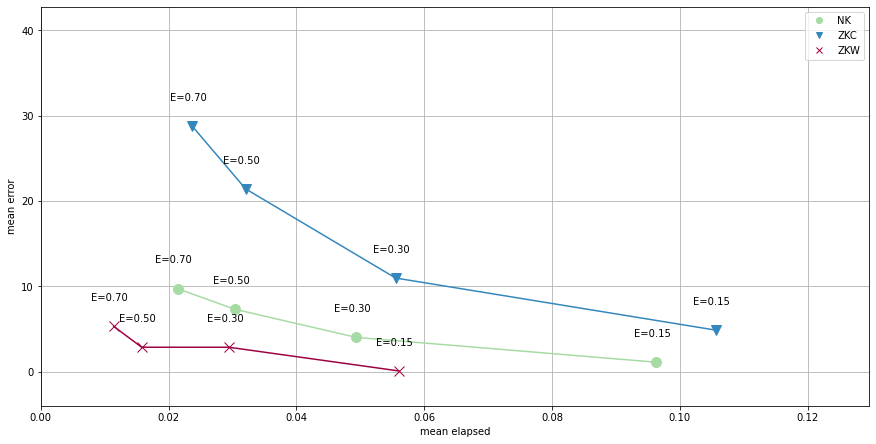

In [36]:
from matplotlib.lines import Line2D
from matplotlib import cm

cmap = cm.get_cmap('Spectral')

fix, ax = plt.subplots(figsize=(12, 6))

max_x = viz.elapsed_mean.max() + 0.024
max_y = viz.delta_mean.max() + 14

d2m = {"ZKW": "x", "NK": "o", "ZKC": "v"}
d2c = {"ZKW": cmap(0), "NK": cmap(180), "ZKC": cmap(230)}

legend_elements = []

for dataset in viz.dataset.unique():
    sub = viz[viz.dataset == dataset]
    color = d2c[dataset]
    
    plt.plot(sub.elapsed_mean, sub.delta_mean, color=color)
    for row in sub.itertuples():
        plt.plot(
            row.elapsed_mean, row.delta_mean, 
            marker=d2m[row.dataset], color=color, label=dataset, markersize = 10
        )
        plt.annotate(row.method, (row.elapsed_mean-0.0035, row.delta_mean+3))

    legend_elements.append(
        Line2D([0], [0], marker=d2m[dataset], color=d2c[dataset], label=dataset, linestyle="None")
    )
    
plt.legend(handles=legend_elements)
plt.grid()

ax.set_ybound(lower=-4, upper=max_y)
ax.set_xbound(lower=0, upper=max_x)

ax.set_xlabel("mean elapsed")
ax.set_ylabel("mean error")
# ax.set_title("FPTAS average error / average time elapsed")

plt.tight_layout(pad=0.1)
plt.savefig('report2/images/fptas_comparison.png')
plt.show()

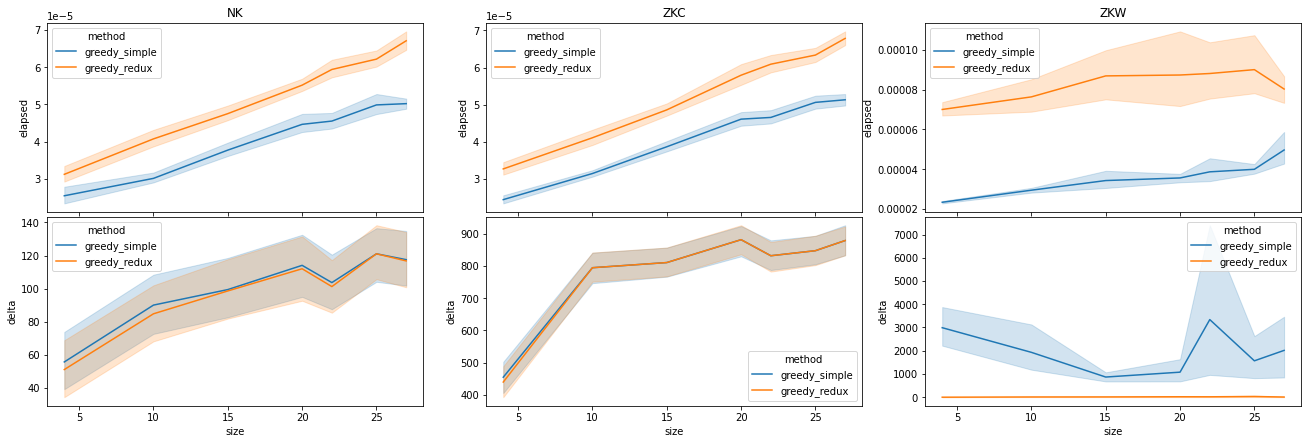

In [29]:
hues = ["greedy_simple", "greedy_redux"]

v = df[df.method.isin(hues)].copy()
fig, ax = plt.subplots(figsize=(18, 6), nrows=2, ncols=3, sharex=True)

for c, dataset in enumerate(['NK', 'ZKC', 'ZKW']):
    select = v[v.dataset == dataset]
    sns.lineplot(data=select, x="size", y="elapsed", hue="method", hue_order=hues, ax=ax[0, c]).set(title=dataset)
    sns.lineplot(data=select, x="size", y="delta", hue="method", hue_order=hues, ax=ax[1, c])

plt.tight_layout(pad=0.1)
plt.savefig('report2/images/greedy_comparison_datasets.png')
plt.show()

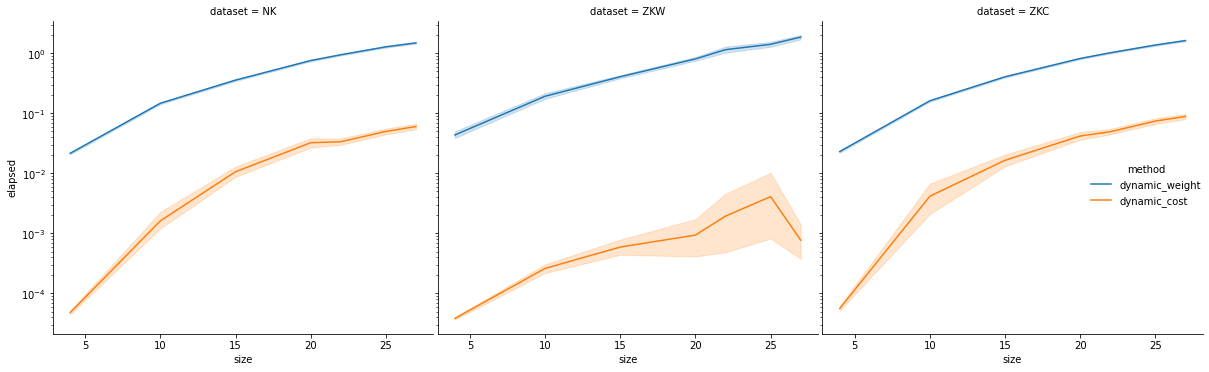

In [30]:
dv = df[df.method.isin(["dynamic_weight", "dynamic_cost"])].copy()

grid = sns.relplot(
    data=dv, x="size", y="elapsed", hue="method", col="dataset", 
    col_order=["NK", "ZKW", "ZKC"], kind="line", legend="full"
)

plt.yscale('log')
plt.tight_layout(pad=0.1)
plt.savefig('report2/images/dynamic_comparison.png')
plt.show()

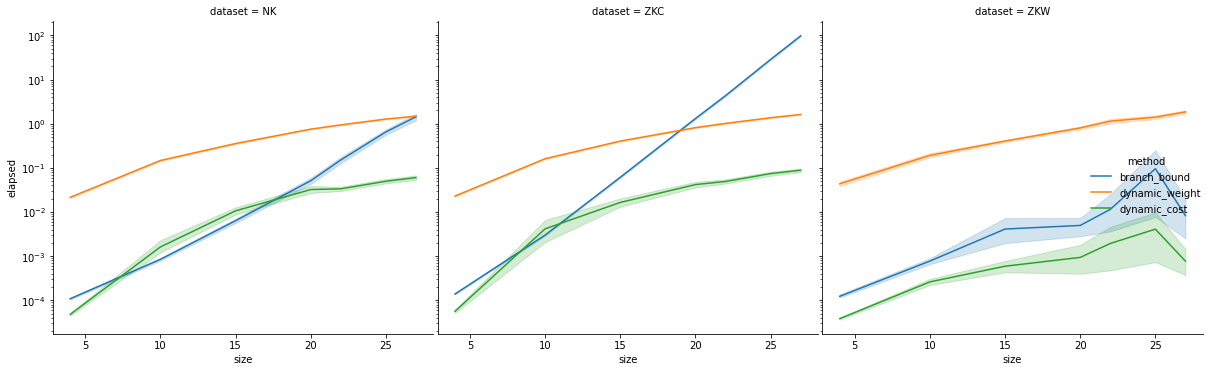

In [31]:
dz = df[df.method.isin(["branch_bound", "dynamic_cost", "dynamic_weight"])]

grid = sns.relplot(
    data=dz, x="size", y="elapsed", hue="method", col="dataset", 
    col_order=["NK", "ZKC", "ZKW"], kind="line", legend="full"
)

plt.yscale('log')
plt.tight_layout(pad=0.1)
plt.savefig('report2/images/exacts_comparison.png')
plt.show()